Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19699s 5s/step - accuracy: 0.7142 - loss: 0.7705 - val_accuracy: 0.7452 - val_loss: 0.7176
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 51450s 14s/step - accuracy: 0.8517 - loss: 0.4035 - val_accuracy: 0.8626 - val_loss: 0.3760
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15692s 4s/step - accuracy: 0.8752 - loss: 0.3379 - val_accuracy: 0.8904 - val_loss: 0.3104
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10610s 3s/step - accuracy: 0.8916 - loss: 0.2983 - val_accuracy: 0.8965 - val_loss: 0.2903
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17016s 5s/step - accuracy: 0.9000 - loss: 0.2715 - val_accuracy: 0.8883 - val_loss: 0.3076
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 44195s 12s/step - accuracy: 0.9082 - loss: 0.2531 - val_accuracy: 0.9059 - val_loss: 0.2663
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10000s 3s/step - accuracy: 0.9131 - loss: 0.2361 - val_accuracy: 0.9012 - val_loss: 0.2848
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23708s 6s/step - accuracy

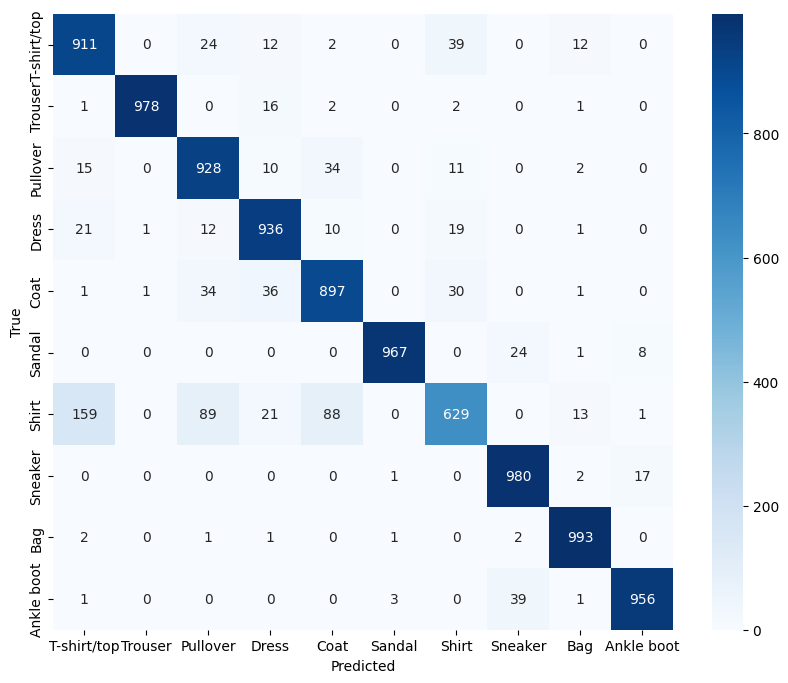

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize and duplicate grayscale channel to match RGB input format
train_images = np.stack((train_images,) * 3, axis=-1) / 255.0  # Convert to (28, 28, 3)
test_images = np.stack((test_images,) * 3, axis=-1) / 255.0

# Resize images to 224x224 to match ResNet50's expected input size
def resize_and_scale(images, labels):
    images = tf.image.resize(images, (224, 224))
    return images, labels

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Create tf.data.Dataset objects for efficient data loading
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(resize_and_scale).map(lambda x, y: (data_augmentation(x), y))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(resize_and_scale).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load ResNet50 with pre-trained ImageNet weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 10 layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers for Fashion MNIST classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces features to a smaller set
x = Dense(256, activation='relu')(x)  # Increased neurons for more complexity
x = Dense(128, activation='relu')(x)  # Additional dense layer
output = Dense(10, activation='softmax')(x)  # Output layer for 10 classes

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model with learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Evaluate and plot confusion matrix
test_predictions = model.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Confusion Matrix
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cm = confusion_matrix(test_labels, test_pred_labels)
plot_confusion_matrix(cm, class_names)

# Save the updated model
model.save('fashion_mnist_resnet50_model.h5')


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import base64
from PIL import Image
import io
import plotly.graph_objs as go

# Load the trained model
model = load_model('fashion_mnist_resnet50_model.h5')

# Define class names for Fashion MNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Layout of the app
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Fashion MNIST Image Classification", className="text-center text-primary mb-4"), width=12)
    ]),
    dbc.Row([
        dbc.Col(dcc.Upload(
            id='upload-image',
            children=html.Div(['Drag and Drop or ', html.A('Select an Image')]),
            style={
                'width': '100%',
                'height': '60px',
                'lineHeight': '60px',
                'borderWidth': '1px',
                'borderStyle': 'dashed',
                'borderRadius': '5px',
                'textAlign': 'center',
                'margin': '10px'
            },
            multiple=False
        ), width=12),
    ]),
    dbc.Row([
        dbc.Col([
            html.H3("Original Image", className="text-center"),
            html.Img(id='original-image', style={'width': '100%', 'height': 'auto'})
        ], width=6),
        dbc.Col([
            html.H3("Prediction", className="text-center"),
            html.Div(id='prediction-output', style={'fontSize': '24px', 'textAlign': 'center'})
        ], width=6),
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='confidence-graph'), width=12)
    ]),
], fluid=True, style={'backgroundColor': '#FFDD57'})  # Set a vibrant background color

# Helper function to preprocess the image for prediction
def preprocess_image(image):
    # Convert to grayscale if the image is in color
    if image.mode != 'L':
        image = image.convert('L')
    # Resize and convert grayscale to 3 channels
    image = image.resize((224, 224))  # Resize to 224x224
    image_np = np.stack((np.array(image) / 255.0,) * 3, axis=-1)  # Normalize and convert to RGB
    image_np = np.expand_dims(image_np, axis=0)  # Add batch dimension
    return image_np

# Callback to update the app based on the uploaded image
@app.callback(
    [Output('original-image', 'src'),
     Output('prediction-output', 'children'),
     Output('confidence-graph', 'figure')],
    [Input('upload-image', 'contents')]
)
def update_output(image_content):
    if image_content is not None:
        try:
            # Decode the uploaded image
            content_type, content_string = image_content.split(',')
            decoded = base64.b64decode(content_string)
            image = Image.open(io.BytesIO(decoded))

            # Display the original image
            original_image_src = image_content

            # Preprocess the image for prediction
            processed_image_np = preprocess_image(image)
            
            # Make prediction using the model
            predictions = model.predict(processed_image_np)
            confidence_scores = predictions[0]
            predicted_class = np.argmax(confidence_scores)
            prediction_text = f"Predicted Class: {class_names[predicted_class]}"

            # Create a bar chart for confidence scores
            confidence_fig = go.Figure(
                data=[
                    go.Bar(
                        x=class_names,
                        y=confidence_scores,
                        text=[f"{score:.2%}" for score in confidence_scores],
                        textposition='auto'
                    )
                ],
                layout=go.Layout(
                    title="Model Confidence Scores",
                    xaxis_title="Class",
                    yaxis_title="Confidence",
                    margin=dict(l=40, r=40, t=40, b=40)
                )
            )

            return original_image_src, prediction_text, confidence_fig

        except Exception as e:
            print(f"Error processing the image: {e}")
            return None, "Error processing image.", go.Figure()

    return None, "No image uploaded.", go.Figure()

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
import matplotlib.pyplot as plt

# Manually input the accuracy and loss values for each epoch
epochs = range(1, 11)

# Training and validation accuracy values (from your log)
train_accuracy = [0.7142, 0.8517, 0.8752, 0.8916, 0.9000, 0.9082, 0.9131, 0.9208, 0.9229, 0.9258]
val_accuracy = [0.7452, 0.8626, 0.8904, 0.8965, 0.8883, 0.9059, 0.9012, 0.9164, 0.9145, 0.9175]

# Training and validation loss values (from your log)
train_loss = [0.7705, 0.4035, 0.3379, 0.2983, 0.2715, 0.2531, 0.2361, 0.2214, 0.2092, 0.1972]
val_loss = [0.7176, 0.3760, 0.3104, 0.2903, 0.3076, 0.2663, 0.2848, 0.2369, 0.2368, 0.2343]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy
ax1.plot(epochs, train_accuracy, label='Training Accuracy', color='b', marker='o')
ax1.plot(epochs, val_accuracy, label='Validation Accuracy', color='r', marker='o')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(epochs, train_loss, label='Training Loss', color='b', marker='o')
ax2.plot(epochs, val_loss, label='Validation Loss', color='r', marker='o')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Display the plot
plt.tight_layout()
plt.show()
